In [1]:
# python libraries
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
import pydot
from IPython.display import HTML, display, SVG, Markdown
# pydrake imports
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    ControllabilityMatrix,
    DiagramBuilder,
    DirectCollocation,
    Expression,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    IsControllable,
    Linearize,
    LinearQuadraticRegulator,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    OutputPortSelection,
    Parser,
    PiecewisePolynomial,
    Simulator,
    Solve,
    StartMeshcat,
    ToLatex,
    Trajectory,
    TrajectorySource,
)

from underactuated import running_as_notebook

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://cc3a4178-1323-4eba-9df3-af3a494426b5.deepnoteproject.com/7000/


### Ballbot URDF structure

- Link 1 : Ball, COM at fixed height with x and y free, sphere of radius equal to COM height
- Link 2 : Body, COM at fixed distance from center of ball, sphere
- Joint 1 : Ball to ground, could be planar but with velocity proportional to rotation
- Joint 2 : Body to ball, want a universal joint, perhaps two revolute joints in place?


In [3]:
def cylinder_moment_of_inertia(mass, height, radius):
    ixx = (1/12)*mass*((3*radius**2) + (height**2))
    iyy = ixx
    izz = (1/2)*mass*radius**2
    return ixx, iyy, izz

print(cylinder_moment_of_inertia(15, 1, 0.1))

(1.2875, 1.2875, 0.07500000000000001)


In [4]:
ballbot_unforced_urdf = f"""
<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="intermediate_ball">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="x" type="prismatic">
        <parent link="world" />
        <child link="intermediate_ball" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>

    <link name="ball">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0.5" />
            <inertia ixx="0.1" iyy="0.1" izz="0.1" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
            <sphere radius="0.1" />
            </geometry>
            <material>
            <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual> 
            <!-- add a visual cue to see when the ball is rolling -->
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
            <box size="0.04 .201 0.002" />
            </geometry>
            <material>
            <color rgba=".1 .1 .1 1" />
            </material>
        </visual>
    </link>
    <joint name="y" type="prismatic">
        <parent link="intermediate_ball" />
        <child link="ball" />
        <origin xyz="0 0 0.1" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>

    <link name="intermediate_body">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="angle_x" type="revolute">
        <parent link="ball" />
        <child link="intermediate_body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>

    <link name="body">
        <inertial>
            <origin xyz="0 0 0.6" rpy="0 0 0"/>
            <mass value="15"/>
            <inertia ixx="1.2875" iyy="1.2875" izz="0.075" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0.6" rpy="0 0 0" />
            <geometry>
                <cylinder radius=".1" length="1" />
            </geometry>
            <material>
                <color rgba="0 1 0 1" />
            </material>
        </visual>
    </link>
    <joint name="angle_y" type="revolute">
        <parent link="intermediate_body" />
        <child link="body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="-1 0 0" />
    </joint>

</robot></xml>
"""
print(ballbot_unforced_urdf)


<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="intermediate_ball">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="x" type="prismatic">
        <parent link="world" />
        <child link="intermediate_ball" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>

    <link name="ball">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0.5" />
            <inertia ixx="0.1" iyy="0.1" izz="0.1" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
            <sphere radius="0.1" />
            </geometry>
            <material>
            <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual> 
            <!-- add a visual cue to see when the ball is rolling -->
            <origin xyz="0 0 0" rpy="0 0 0" />
        

In [5]:
ballbot_obstacles_urdf = f"""
<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="obstacle1">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs1" type="fixed">
        <parent link="world" />
        <child link="obstacle1" />
        <origin xyz="0 0.5 0" />
    </joint>

    <link name="obstacle2">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs2" type="fixed">
        <parent link="world" />
        <child link="obstacle2" />
        <origin xyz="0.25 1.5 0" />
    </joint>

    <link name="obstacle3">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs3" type="fixed">
        <parent link="world" />
        <child link="obstacle3" />
        <origin xyz="0.5 1 0" />
    </joint>

    <link name="obstacle4">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs4" type="fixed">
        <parent link="world" />
        <child link="obstacle4" />
        <origin xyz="-0.5 1 0" />
    </joint>

    <link name="obstacle5">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs5" type="fixed">
        <parent link="world" />
        <child link="obstacle5" />
        <origin xyz="-0.25 1.5 0" />
    </joint>

    <link name="intermediate_ball">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="x" type="prismatic">
        <parent link="world" />
        <child link="intermediate_ball" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>
    <transmission type="SimpleTransmission" name="x-force">
        <actuator name="x-force-actuator" />
        <joint name="x" />
    </transmission>

    <link name="ball">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0.5" />
            <inertia ixx="0.1" iyy="0.1" izz="0.1" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
            <sphere radius="0.1" />
            </geometry>
            <material>
            <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual> 
            <!-- add a visual cue to see when the ball is rolling -->
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
            <box size="0.04 .201 0.002" />
            </geometry>
            <material>
            <color rgba=".1 .1 .1 0" />
            </material>
        </visual>
    </link>
    <joint name="y" type="prismatic">
        <parent link="intermediate_ball" />
        <child link="ball" />
        <origin xyz="0 0 0.1" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>
    <transmission type="SimpleTransmission" name="y-force">
        <actuator name="y-force-actuator" />
        <joint name="y" />
    </transmission>

    <link name="intermediate_body">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="angle_x" type="revolute">
        <parent link="ball" />
        <child link="intermediate_body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>

    <link name="body">
        <inertial>
            <origin xyz="0 0 0.6" rpy="0 0 0"/>
            <mass value="15"/>
            <inertia ixx="1.2875" iyy="1.2875" izz="0.075" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0.6" rpy="0 0 0" />
            <geometry>
                <cylinder radius=".1" length="1" />
            </geometry>
            <material>
                <color rgba="0 1 0 1" />
            </material>
        </visual>
    </link>
    <joint name="angle_y" type="revolute">
        <parent link="intermediate_body" />
        <child link="body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="-1 0 0" />
    </joint>

</robot></xml>
"""
print(ballbot_obstacles_urdf)


<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="obstacle1">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs1" type="fixed">
        <parent link="world" />
        <child link="obstacle1" />
        <origin xyz="0 0.5 0" />
    </joint>

    <link name="obstacle2">
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.1" length="0.2" />
            </geometry>
            <material>
                <color rgba="0 0 0 1" />
            </material>
        </visual>
    </link>
    <joint name="obs2" type="fixed">
        <parent link="world" />
        <child link="obstacle2" />
        <origin xyz="0.25 1.5 0" />
    </joint>

    <link name="obstacle3">
    

In [6]:
ballbot_urdf = f"""
<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="intermediate_ball">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="x" type="prismatic">
        <parent link="world" />
        <child link="intermediate_ball" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>
    <transmission type="SimpleTransmission" name="x-force">
        <actuator name="x-force-actuator" />
        <joint name="x" />
    </transmission>

    <link name="ball">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0.5" />
            <inertia ixx="0.1" iyy="0.1" izz="0.1" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
            <sphere radius="0.1" />
            </geometry>
            <material>
            <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual> 
            <!-- add a visual cue to see when the ball is rolling -->
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
            <box size="0.04 .201 0.002" />
            </geometry>
            <material>
            <color rgba=".1 .1 .1 0" />
            </material>
        </visual>
    </link>
    <joint name="y" type="prismatic">
        <parent link="intermediate_ball" />
        <child link="ball" />
        <origin xyz="0 0 0.1" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>
    <transmission type="SimpleTransmission" name="y-force">
        <actuator name="y-force-actuator" />
        <joint name="y" />
    </transmission>

    <link name="intermediate_body">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="angle_x" type="revolute">
        <parent link="ball" />
        <child link="intermediate_body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="0 1 0" />
    </joint>

    <link name="body">
        <inertial>
            <origin xyz="0 0 0.6" rpy="0 0 0"/>
            <mass value="15"/>
            <inertia ixx="1.2875" iyy="1.2875" izz="0.075" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0.6" rpy="0 0 0" />
            <geometry>
                <cylinder radius=".1" length="1" />
            </geometry>
            <material>
                <color rgba="0 1 0 1" />
            </material>
        </visual>
    </link>
    <joint name="angle_y" type="revolute">
        <parent link="intermediate_body" />
        <child link="body" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="-1 0 0" />
    </joint>

</robot></xml>
"""
print(ballbot_urdf)


<?xml version="1.0"?><robot name="ballbot">
<!-- comment -->

    <link name="intermediate_ball">
        <inertial>
            <origin xyz="0 0 0"/>
            <mass value="0"/>
        </inertial>
    </link>
    <joint name="x" type="prismatic">
        <parent link="world" />
        <child link="intermediate_ball" />
        <origin xyz="0 0 0" rpy="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>
    <transmission type="SimpleTransmission" name="x-force">
        <actuator name="x-force-actuator" />
        <joint name="x" />
    </transmission>

    <link name="ball">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0.5" />
            <inertia ixx="0.1" iyy="0.1" izz="0.1" ixy="0" ixz="0" iyz="0"/>
        </inertial>
        <visual>
            <origin xyz="0 0 0" />
            <geometry>
            <sphere radius="0.1" />
            </geometry>
            <material>
            <color rgba="1 0 0 1" />
            </material>
        <

In [7]:
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(ballbot_urdf, 'urdf')
visualizer.Run(loop_once=not running_as_notebook)
meshcat.Delete()
meshcat.DeleteAddedControls()

Click 'Stop Running' or press Esc to quit


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [8]:
def ballbot_unforced(urdf):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    logger = LogVectorOutput(plant.get_state_output_port(), builder)

    context = plant.CreateDefaultContext()
    print("state vector size:", plant.num_continuous_states())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # build the block diagram
    diagram = builder.Build()
    return diagram, logger

In [9]:
def ballbot_const_input(urdf, gamma_input, theta_input):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    logger = LogVectorOutput(plant.get_state_output_port(), builder)

    # Just use zero instead of a controller to start
    command = builder.AddSystem(ConstantVectorSource([float(gamma_input), float(theta_input)]))
    builder.Connect(
        command.get_output_port(), plant.get_actuation_input_port()
    )

    context = plant.CreateDefaultContext()
    print("state vector size:", plant.num_continuous_states())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # build the block diagram
    diagram = builder.Build()
    return diagram, logger

In [10]:
def ballbot_lqr(urdf, x_star, Q, R):

    """
    Arguments: 
        urdf: str
            a string that contains a urdf description of the system
        x_star: array
            a fixed point of the system; the desired equilibrium point 
            we want the system to reach
        Q: state cost matrix in LQR
        R: input cost matrix in LQR

    simulates and generates an animation for the lqr controlled system
    """

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)
    

    # TODO: 
    # 1. obtain the context from the cartpole plant
    # 2. set the state vector in the context to x_star
    # 3. fix the actuation input port to zero
    # 4. synthesize a LinearQuadraticRegulator, and add it to the builder
    # 5. wire cart-pole and lqr

    context = plant.CreateDefaultContext()
    print("state vector size:", plant.num_continuous_states())
    context.SetContinuousState(x_star)
    plant.get_actuation_input_port().FixValue(context,[0, 0])

    linear = Linearize(
        plant,
        context,
        input_port_index=plant.get_actuation_input_port().get_index(),
        output_port_index=OutputPortSelection.kNoOutput
    )

    np.set_printoptions(precision=2, suppress=True)
    print("Linear System Parameters")
    display(Markdown("$A = " + ToLatex(linear.A()) + "$"))
    print(ToLatex(linear.A()))
    display(Markdown("$B = " + ToLatex(linear.B()) + "$"))
    print(ToLatex(linear.B()))
    display(
        Markdown("$ctrb(A,B) = " + ToLatex(ControllabilityMatrix(linear), 6)
                + "$"))
    display(Markdown(f"Is controllable? {IsControllable(linear)}"))
    ctrb = ControllabilityMatrix(linear)
    print("Controllability matrix rank:", np.linalg.matrix_rank(ctrb))
    ctrb_subspace = sp.linalg.orth(ctrb)
    display(Markdown("$ImC = " + ToLatex(ctrb_subspace) + "$"))

    controller = builder.AddSystem(LinearQuadraticRegulator(
        plant,
        context,
        Q,
        R,
        input_port_index=plant.get_actuation_input_port().get_index()))
    
    input_logger = LogVectorOutput(controller.get_output_port(), builder)

    print("K matrix:", controller.D())

    builder.Connect(plant.get_state_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # finish building the block diagram
    diagram = builder.Build()
    return diagram, state_logger, input_logger

In [11]:
def ballbot_dircol(urdf, x0, xf, Q, R):

    ## Create diagram, plant, context
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)

    context = plant.CreateDefaultContext()
    print("state vector size:", plant.num_continuous_states())
    # context.SetContinuousState(x0)
    # plant.get_actuation_input_port().FixValue(context,[0, 0])

    ## Set up trajectory optimization
    N = 20
    torque_limit = 350
    leanangle_limit = 1

    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=N,
        minimum_timestep=0.05,
        maximum_timestep=0.5,
        input_port_index=plant.get_actuation_input_port().get_index()
    )
    prog = dircol.prog()
    u = dircol.input()
    x = dircol.state()

    ## Set up constraints

    # Start and end point
    prog.AddBoundingBoxConstraint(x0, x0, dircol.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dircol.final_state())

    # Equal time intervals
    dircol.AddEqualTimeIntervalsConstraints()

    # Input limits
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[1] <= torque_limit)

    # State limits
    dircol.AddConstraintToAllKnotPoints(-leanangle_limit <= x[2])
    dircol.AddConstraintToAllKnotPoints(x[2] <= leanangle_limit)
    dircol.AddConstraintToAllKnotPoints(-leanangle_limit <= x[3])
    dircol.AddConstraintToAllKnotPoints(x[3] <= leanangle_limit)

    # Input cost
    # dircol.AddRunningCost(R * (u[0]**2 + u[1]**2))
    dircol.AddRunningCost(
        (R[0,0]*u[0]**2) +
        (R[1,1]*u[1]**2) +
        (Q[0,0]*(x[0]-xf[0])**2) +
        (Q[1,1]*(x[1]-xf[1])**2) +
        (Q[2,2]*x[2]**2) +
        (Q[3,3]*x[3]**2) +
        (Q[4,4]*x[4]**2) +
        (Q[5,5]*x[5]**2) +
        (Q[6,6]*x[6]**2) +
        (Q[7,7]*x[7]**2)
    )
    dircol.AddFinalCost(dircol.time())

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 0.1], np.column_stack((x0, xf))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    ## Solve and extract trajectories
    print("Attempting solve")
    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    duration = u_trajectory.end_time() - u_trajectory.start_time()
    timestep = duration / N

    ## Set up finite horizon LQR
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory
    options.Qf = Q
    options.input_port_index = plant.get_actuation_input_port().get_index()

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            plant,
            context,
            t0=options.u0.start_time(),
            tf=options.u0.end_time(),
            Q=np.eye(8),
            R=np.eye(2),
            options=options,
        )
    )
    builder.Connect(plant.get_state_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    
    # print("x cols", x_trajectory.cols())
    # print("u cols", u_trajectory.cols())

    # np.set_printoptions(precision=4, suppress=True)
    # print(u_trajectory.vector_values(np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), N)))

    # fig, ax = plt.subplots()

    # x_knots = np.hstack(
    #     [
    #         x_trajectory.value(t)
    #         for t in np.linspace(
    #             x_trajectory.start_time(), x_trajectory.end_time(), N
    #         )
    #     ]
    # )

    # # define trajectory sources for each input

    # command = builder.AddSystem(TrajectorySource(
    #     trajectory=u_trajectory,
    #     output_derivative_order=0,
    # ))
    # builder.Connect(command.get_output_port(), plant.get_actuation_input_port())

    # ax.set_xlabel("$x$")
    # ax.set_ylabel("$y$")
    # ax.plot(x_knots[0, :], x_knots[1, :])
    # display(plt.show())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # finish building the block diagram
    diagram = builder.Build()
    return diagram, state_logger, input_logger, duration

In [12]:
def ballbot_dircol_circular_orbit(urdf, state_cost, input_cost, time_cost, v):

    ## Create diagram, plant, context
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)

    context = plant.CreateDefaultContext()
    print("state vector size:", plant.num_continuous_states())
    # context.SetContinuousState(x0)
    # plant.get_actuation_input_port().FixValue(context,[0, 0])

    ## Set up trajectory optimization
    N = 50
    torque_limit = 1000
    leanangle_limit = 1.4

    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=N,
        minimum_timestep=0.05,
        maximum_timestep=0.5,
        input_port_index=plant.get_actuation_input_port().get_index()
    )
    prog = dircol.prog()
    u = dircol.input()
    x = dircol.state()

    ## Set up constraints

    # Start and end point constraints
    prog.AddConstraint(dircol.initial_state()[0] == 0)
    prog.AddConstraint(dircol.initial_state()[1] >= 0)
    for i in range(0, dircol.initial_state().size):
        prog.AddConstraint(dircol.initial_state()[i] == dircol.final_state()[i])

    # Norm constraints (uniform circular motion)
    dist = prog.NewContinuousVariables(1, "dist")
    dircol.AddConstraintToAllKnotPoints((x[4]**2 + x[5]**2) == v**2) # Constant groundspeed
    dircol.AddConstraintToAllKnotPoints((x[0]**2 + x[1]**2) == dist[0]) # Constant distance from origin

    # Equal time intervals
    dircol.AddEqualTimeIntervalsConstraints()

    # Some costs
    dircol.AddFinalCost(2*dircol.time())
    dircol.AddRunningCost(0.001*(u[0]**2 + u[1]**2))
    dircol.AddRunningCost(0.3*(x[0]**2 + x[1]**2))

    # Input limits
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[1] <= torque_limit)

    x0 = np.array([ 0, 1, 0.5, 0,  v,  0, 0, 0])
    x1 = np.array([ 1, 0, 0, -0.5, 0, -v, 0, 0])
    x2 = np.array([ 0,-1, -0.5, 0,  -v,  0, 0, 0])
    x3 = np.array([-1, 0, 0, 0.5, 0,  v, 0, 0])
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 2.5, 5.0, 7.5, 10.0], np.column_stack(( x0, x1, x2, x3, x0 ))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    ## Solve and extract trajectories
    print("Attempting solve")
    result = Solve(prog)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    duration = u_trajectory.end_time() - u_trajectory.start_time()
    timestep = duration / N

    ## Set up finite horizon LQR
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory
    options.Qf = Q
    options.input_port_index = plant.get_actuation_input_port().get_index()

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            plant,
            context,
            t0=options.u0.start_time(),
            tf=options.u0.end_time(),
            Q=np.eye(8),
            R=np.eye(2),
            options=options,
        )
    )
    builder.Connect(plant.get_state_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    
    # print("x cols", x_trajectory.cols())
    # print("u cols", u_trajectory.cols())

    # np.set_printoptions(precision=4, suppress=True)
    # print(u_trajectory.vector_values(np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), N)))

    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), N
            )
        ]
    )

    # # define trajectory sources for each input
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # finish building the block diagram
    diagram = builder.Build()
    return diagram, state_logger, input_logger, duration, x_trajectory.value(0).T[0]

In [27]:
def ballbot_dircol_obstacle_avoidance(urdf, obstacle_list, obstacle_radius, x0, xf, state_cost, input_cost, time_cost):

    ## Create diagram, plant, context
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelsFromString(urdf, "urdf")
    plant.Finalize()
    plant.set_name("ballbot")

    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)

    context = plant.CreateDefaultContext()

    ## Set up trajectory optimization
    N = 25
    torque_limit = 350
    leanangle_limit = 1

    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=N,
        minimum_timestep=0.01,
        maximum_timestep=0.5,
        input_port_index=plant.get_actuation_input_port().get_index()
    )
    prog = dircol.prog()
    u = dircol.input()
    x = dircol.state()

    ## Set up constraints

    # Start and end point
    prog.AddBoundingBoxConstraint(x0, x0, dircol.initial_state())
    prog.AddBoundingBoxConstraint(xf, xf, dircol.final_state())

    # Equal time intervals
    dircol.AddEqualTimeIntervalsConstraints()

    # Time cost
    dircol.AddFinalCost(100*time_cost*dircol.time())

    # Obstacle avoidance
    if obstacle_list is not None:
        for obstacle in obstacle_list:
            print(obstacle)
            dircol.AddConstraintToAllKnotPoints((x[0] - obstacle[0])**2 + (x[1] - obstacle[1])**2 >= (obstacle_radius + 0.12)**2)

    # Input limits
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[1] <= torque_limit)

    # State limits
    dircol.AddConstraintToAllKnotPoints(-leanangle_limit <= x[2])
    dircol.AddConstraintToAllKnotPoints(x[2] <= leanangle_limit)
    dircol.AddConstraintToAllKnotPoints(-leanangle_limit <= x[3])
    dircol.AddConstraintToAllKnotPoints(x[3] <= leanangle_limit)

    # Input cost
    dircol.AddRunningCost(input_cost*0.001*(u[0]**2 + u[1]**2) + state_cost*10*(x[1] - xf[1])**2)
    
    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 10.0], np.column_stack(( x0, xf ))
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    ## Solve and extract trajectories
    print("Attempting solve")
    start_time = time.perf_counter_ns()
    result = Solve(prog)
    end_time = time.perf_counter_ns()
    solve_time = end_time - start_time
    print("Solve time ns:", solve_time)
    assert result.is_success()

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    duration = u_trajectory.end_time() - u_trajectory.start_time()
    timestep = duration / N

    ## Set up finite horizon LQR
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = x_trajectory
    options.u0 = u_trajectory
    options.Qf = Q
    options.input_port_index = plant.get_actuation_input_port().get_index()

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            plant,
            context,
            t0=options.u0.start_time(),
            tf=options.u0.end_time(),
            Q=np.eye(8),
            R=np.eye(2),
            options=options,
        )
    )
    builder.Connect(plant.get_state_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    
    # print("x cols", x_trajectory.cols())
    # print("u cols", u_trajectory.cols())

    # np.set_printoptions(precision=4, suppress=True)
    # print(u_trajectory.vector_values(np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), N)))

    u_knots = np.hstack(
        [
            u_trajectory.value(t)
            for t in np.linspace(
                u_trajectory.start_time(), u_trajectory.end_time(), N
            )
        ]
    )

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), N
            )
        ]
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((6, 6)))
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    ax1.plot(x_knots[0, :], x_knots[1, :])
    ax2.set_xlabel("$u_x$")
    ax2.set_ylabel("$u_y$")
    ax2.plot(u_knots[0, :], u_knots[1, :])
    display(plt.show())

    # add a visualizer
    meshcat.Delete()
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    visualizer.set_name("visualizer")

    # finish building the block diagram
    diagram = builder.Build()
    return diagram, state_logger, input_logger, duration

In [14]:
def simulate_and_animate(diagram, state_logger, input_logger, x0, sim_time=5.):
    # instantiate a simulator
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False) # makes sim faster
    simulator.get_mutable_integrator().set_fixed_step_mode(True)

    # start recording the video for the animation of the simulation
    visualizer = diagram.GetSubsystemByName("visualizer")
    visualizer.StartRecording(False)

    if (len(x0) !=
            diagram.GetSubsystemByName("ballbot").num_continuous_states()):
        print(f"Your plant doesn't have {len(x0)} state variables.")
        return

    # reset initial time and state
    context = simulator.get_mutable_context()
    context.SetTime(0.)
    context.SetContinuousState(x0)

    # run sim
    simulator.Initialize()
    simulator.AdvanceTo(sim_time)

    # stop video
    visualizer.PublishRecording()
    visualizer.DeleteRecording()

    # states to visualize
    state_index = [0,1,2,3,4,5]
    state_names = ["x", "y", "angle_x", "angle_y", "xdot", "ydot"]

    # inputs to visualize
    input_index = [0,1]
    input_names = ["u_x", "u_y"]

    state_log = state_logger.FindLog(context)
    if (input_logger == None):
        fig, ax1 = plt.subplots(1, 1, figsize=((10, 6)))
        ax1.plot(state_log.sample_times(), state_log.data()[state_index, :].T)
        ax1.legend(state_names)
    else:
        input_log = input_logger.FindLog(context)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=((5, 15)))
        # fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax1.plot(state_log.sample_times(), state_log.data()[state_index, :].T)
        ax1.legend(state_names)
        # ax.axis('equal')
        ax1.grid(visible=True, which='both', axis='both')
        # plt.show()

        # fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax2.plot(input_log.sample_times(), input_log.data()[input_index, :].T)
        ax2.legend(input_names)
        ax2.grid(visible=True, which='both', axis='both')
        # plt.show()

        # fig, ax = plt.subplots(1, 1, figsize=(10,10))
        ax3.plot(state_log.data()[0, :].T, state_log.data()[1,:].T)
        ax3.axis('equal')
        ax3.grid(visible=True, which='both', axis='both')
        ax3.set_xlabel("x position")
        ax3.set_ylabel("y position")
        # plt.show()


In [15]:
# simulate and animate the lqr controller for single-pendulum cart-pole
Q = np.diag((1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1))
R = np.diag((0.001, 0.001))

# x, y, gamma, theta, xdot, ydot, gammadot, thetadot
x_star = np.zeros((8))
x0_sideways_lean = np.array([0, 0, 0.5, 0, 0, 0, 0, 0])
x0_diagonal_lean = np.array([0, 0, 0.6, 0.6, 0, 0, 0, 0])
x0_positive_thetadot = np.array([0, 0, 0, 0, 0, 0, 0, 1])
x0_canceling_theta = np.array([0, 0, 0 , 0.4, 0, 0, 0, -2.48])
x0_off_origin = np.array([-2, 0, 0, 0, 0, 0, 0, 0])
x0_dynamic_1 = np.array([-2, 0, 0.6, 0, -2, 0, 0, 1])
x0_dynamic_2 = np.array([-1, 0, 0, 0, 0, 5, 0, 0])
x0_dynamic_3 = np.array([-1, 0, 0, 0, 0, 1, 0, 0])

x0_90turn = np.array([0, -1, 0, 0, 0, 3, 0, 0])
xf_90turn = np.array([1, 0, 0, 0, 3, 0, 0, 0])
x0_270turn = np.array([0, -1, 0, 0, 0, 10, 0, 0])
xf_270turn = np.array([1, 0, 0, 0, 10, 0, 0, 0])

xf_obstacle_1 = np.array([0, 3, 0, 0, 0, 0, 0, 0])
obstacle_list1 = np.array([
    [0, 0.5],
    [0.5, 1],
    [-0.5, 1],
    [0.25, 1.5],
    [-0.25, 1.5]
])

# x0_turn_1 = np.array([0, -0.5, 0, 0, 0, 5, 0, 0])
# xf_turn_1 = np.array([0.5, 0, 0, 0, 5, 0, 0, 0])


diagram_uf, state_logger_uf = ballbot_unforced(ballbot_unforced_urdf) # unforced
diagram_lqr, state_logger_lqr, input_logger_lqr = ballbot_lqr(ballbot_urdf, x_star, Q, R) # lqr

state vector size: 8
state vector size: 8
Linear System Parameters


$A = \begin{bmatrix} 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & -35.072 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & -35.072 & 0 & 0 & 0 & 0 \\ 0 & 0 & 60.403 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 60.403 & 0 & 0 & 0 & 0 \end{bmatrix}$

\begin{bmatrix} 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & -35.072 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & -35.072 & 0 & 0 & 0 & 0 \\ 0 & 0 & 60.403 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 60.403 & 0 & 0 & 0 & 0 \end{bmatrix}


$B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0.295 & 0 \\ 0 & 0.295 \\ -0.397 & 0 \\ 0 & -0.397 \end{bmatrix}$

\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0.295 & 0 \\ 0 & 0.295 \\ -0.397 & 0 \\ 0 & -0.397 \end{bmatrix}


$ctrb(A,B) = \begin{bmatrix} 0 & 0 & 0.295172 & 0 & 0 & 0 & 13.932225 & 0 & 0 & 0 & 841.541748 & 0 & 0 & 0 & 50831.257377 & 0 \\ 0 & 0 & 0 & 0.295172 & 0 & 0 & 0 & 13.932225 & 0 & 0 & 0 & 841.541748 & 0 & 0 & 0 & 50831.257377 \\ 0 & 0 & -0.397241 & 0 & 0 & 0 & -23.994387 & 0 & 0 & 0 & -1449.321900 & 0 & 0 & 0 & -87542.721038 & 0 \\ 0 & 0 & 0 & -0.397241 & 0 & 0 & 0 & -23.994387 & 0 & 0 & 0 & -1449.321900 & 0 & 0 & 0 & -87542.721038 \\ 0.295172 & 0 & 0 & 0 & 13.932225 & 0 & 0 & 0 & 841.541748 & 0 & 0 & 0 & 50831.257377 & 0 & 0 & 0 \\ 0 & 0.295172 & 0 & 0 & 0 & 13.932225 & 0 & 0 & 0 & 841.541748 & 0 & 0 & 0 & 50831.257377 & 0 & 0 \\ -0.397241 & 0 & 0 & 0 & -23.994387 & 0 & 0 & 0 & -1449.321900 & 0 & 0 & 0 & -87542.721038 & 0 & 0 & 0 \\ 0 & -0.397241 & 0 & 0 & 0 & -23.994387 & 0 & 0 & 0 & -1449.321900 & 0 & 0 & 0 & -87542.721038 & 0 & 0 \end{bmatrix}$

Is controllable? True

Controllability matrix rank: 8


$ImC = \begin{bmatrix} 0.000 & -0.000 & -0.502 & -0.000 & 0.611 & 0 & 0 & -0.611 \\ -0.502 & -0.000 & 0 & -0.000 & -0.000 & -0.611 & 0.612 & -0.000 \\ -0.000 & -0.000 & 0.865 & -0.000 & 0.355 & 0 & 0 & -0.355 \\ 0.865 & -0.000 & 0 & 0.000 & -0.000 & -0.355 & 0.355 & -0.000 \\ 0.000 & -0.000 & -0.000 & 0.502 & -0.611 & 0.000 & -0.000 & -0.611 \\ -0.000 & -0.502 & 0 & -0.000 & 0.000 & 0.612 & 0.611 & 0.000 \\ 0.000 & -0.000 & 0.000 & -0.865 & -0.355 & 0.000 & 0.000 & -0.355 \\ 0.000 & 0.865 & 0 & 0.000 & -0.000 & 0.355 & 0.355 & -0.000 \end{bmatrix}$

K matrix: [[ 31.62  -0.   429.67  -0.    43.47  -0.    79.21  -0.  ]
 [ -0.    31.62  -0.   429.67  -0.    43.47  -0.    79.21]]


[0.  0.5]
[0.5 1. ]
[-0.5  1. ]
[0.25 1.5 ]
[-0.25  1.5 ]
Attempting solve
Solve time ns: 16575526539


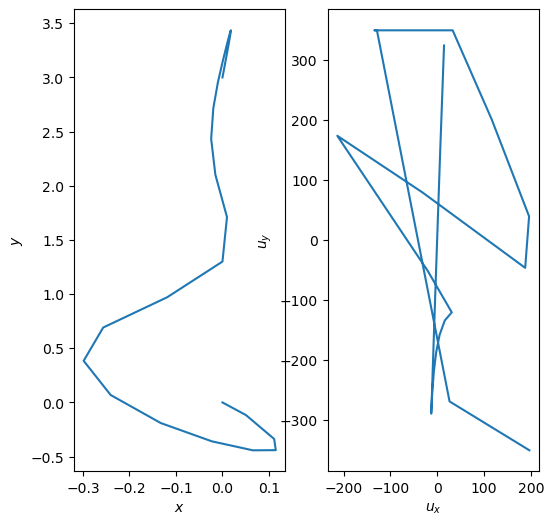

None

In [28]:
# trajopt sideways lean
# diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol(ballbot_urdf, x0_sideways_lean, x_star, Q, R)

# trajopt dynamic 1
# diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol(ballbot_urdf, x0_dynamic_1, x_star, Q, R)

# trajopt dynamic 2
# diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol(ballbot_urdf, x0_dynamic_2, x_star, Q, R)

# trajopt dynamic 3
# diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol(ballbot_urdf, x0_dynamic_3, x_star, Q, R)

# trajopt circular orbit
# diagram_dc, state_logger_dc, input_logger_dc, T, x0_circular_orbit = ballbot_dircol_circular_orbit(ballbot_urdf, 0.1, 0.001, 2, 5)

# trajopt obstacle avoidance
diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol_obstacle_avoidance(ballbot_obstacles_urdf, obstacle_list1, 0.2, x_star, xf_obstacle_1, 5, 1, 1)

# trajopt u turn
# diagram_dc, state_logger_dc, input_logger_dc, T = ballbot_dircol_obstacle_avoidance(ballbot_urdf, None, 0.1, x0_turn_1, xf_turn_1, 0, 1, 1)

# trajopt turn 90
# diagram_dc90, state_logger_dc90, input_logger_dc90, T90 = ballbot_dircol_obstacle_avoidance(ballbot_urdf, None, 0.1, x0_90turn, xf_90turn, 0, 1, 2)

# trajopt turn 270
# diagram_dc270, state_logger_dc270, input_logger_dc270, T270 = ballbot_dircol_obstacle_avoidance(ballbot_urdf, None, 0.1, x0_270turn, xf_270turn, 0, 1, 2)


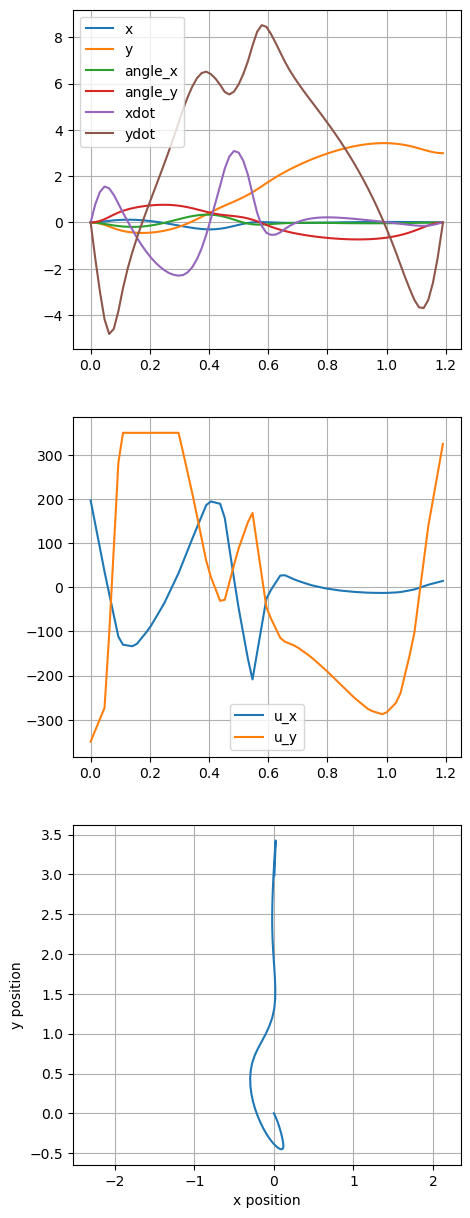

In [29]:
# unforced off origin
# simulate_and_animate(diagram_uf, state_logger_uf, None, x0_off_origin, sim_time=0.5)

# unforced sideways lean
# simulate_and_animate(diagram_uf, state_logger_uf, None, x0_sideways_lean, sim_time=0.5)

# unforced diagonal lean
# simulate_and_animate(diagram_uf, state_logger_uf, None, x0_diagonal_lean, sim_time=0.5)

# unforced positive lean rate
# simulate_and_animate(diagram_uf, state_logger_uf, None, x0_positive_thetadot, sim_time=0.7)

# unforced canceling theta
# simulate_and_animate(diagram_uf, state_logger_uf, None, x0_canceling_theta, sim_time=0.85)

# lqr sideways lean
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_sideways_lean, sim_time=5)

# lqr diagonal lean
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_diagonal_lean, sim_time=4)

# lqr positive thetadot
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_positive_thetadot, sim_time=10)

# lqr off origin
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_off_origin, sim_time=4)

# lqr dynamic 1
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_dynamic_1, sim_time=2)

# lqr dynamic 2
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_dynamic_2, sim_time=5)

# lqr dynamic 3
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_dynamic_3, sim_time=5)

# lqr turn 90
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_90turn, sim_time=10)

# lqr turn 270
# simulate_and_animate(diagram_lqr, state_logger_lqr, input_logger_lqr, x0_270turn, sim_time=4)

# trajopt sideways lean
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_sideways_lean, sim_time=T)

# trajopt dynamic 1
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_dynamic_1, sim_time=T)

# trajopt dynamic 2
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_dynamic_2, sim_time=T)

# trajopt dynamic 3
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_dynamic_3, sim_time=T)

# trajopt circular orbit
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_circular_orbit, sim_time=T)

# trajopt obstacle avoidance
simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x_star, sim_time=T)

# trajopt u turn
# simulate_and_animate(diagram_dc, state_logger_dc, input_logger_dc, x0_turn_1, sim_time=T)

# trajopt quick turn 90
# simulate_and_animate(diagram_dc90, state_logger_dc90, input_logger_dc90, x0_90turn, sim_time=T90)

# trajopt quick turn 270
# simulate_and_animate(diagram_dc270, state_logger_dc270, input_logger_dc270, x0_270turn, sim_time=T270)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc3a4178-1323-4eba-9df3-af3a494426b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>